# Importing the necessary libraries

In [33]:
import ee
import geemap
from matplotlib import pyplot as plt
import numpy as np
import PIL
import math

In [4]:
# Initialise Earth Engine
ee.Authenticate()
ee.Initialize(project='directed-sun-356611')

In [5]:
# Duration
# date_from = '2016-12-16'
# date_to = '2016-12-17'
date_from = '2021-05-01'
date_to = '2021-06-01'
aoi = geemap.geojson_to_ee('data/warrumbungle_national_park.geojson')

# Rainfall

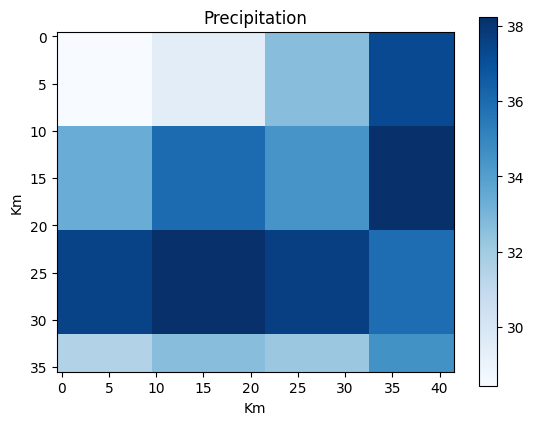

In [20]:
precipitation = ee.ImageCollection('JAXA/GPM_L3/GSMaP/v6/operational').filterDate(date_from, date_to).select('hourlyPrecipRate').sum().clip(aoi)

precipitationVis = {
  'min': 0.0,
  'max': 30.0,
  'palette': ['1621a2', 'ffffff', '03ffff', '13ff03', 'efff00', 'ffb103', 'ff2300'],
}

Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(precipitation, precipitationVis, 'Precipitation')
Map.to_html('maps/precipitation.html')

# to array
precipitation_array = geemap.ee_to_numpy(precipitation, region=aoi, scale=1000)
plt.title("Precipitation")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(precipitation_array, cmap='Blues')
plt.colorbar()
plt.savefig('images/precipitation.png')
plt.show()

# Storm Kinetic Energy
$$
E = \sum_{r=1}^{N} 0.29\left[1 - 0.72\exp\left(-\alpha\frac{\Delta V_r}{\Delta t_r}\right)\right]\Delta V_r
$$

In [21]:
# E_r = 0.29 * [1 - 0.72 * exp(-0.082 * (P_daily/24))] * P_daily/N

P_daily = precipitation
N = 24
E = ee.Image(0.29).multiply(
    ee.Image(1).subtract(
        ee.Image(0.72).multiply(
            ee.Image(0.082).multiply(P_daily.divide(24)).exp()
        )
    )
).multiply(P_daily.divide(N))


$$
I_{30} = P_{60} ?
$$

In [22]:
peak_rainfall = precipitation = ee.ImageCollection('JAXA/GPM_L3/GSMaP/v6/operational').filterDate(date_from, date_to).select('hourlyPrecipRate').max().clip(aoi)

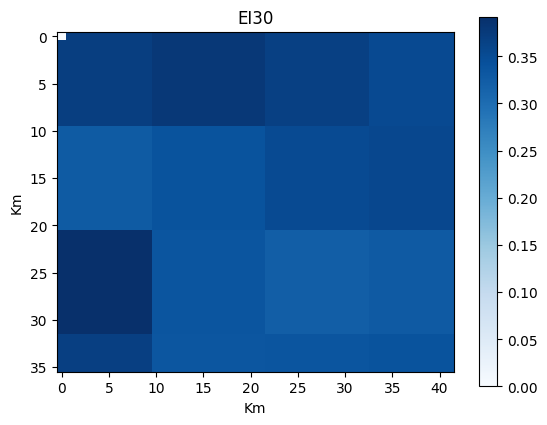

In [23]:
# EI30
EI30 = E.multiply(peak_rainfall)
EI30_array = geemap.ee_to_numpy(EI30, region=aoi, scale=1000)

plt.title("EI30")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(EI30_array, cmap='Blues')
plt.colorbar()
plt.savefig('images/ei30.png')
plt.show()

# K Factor


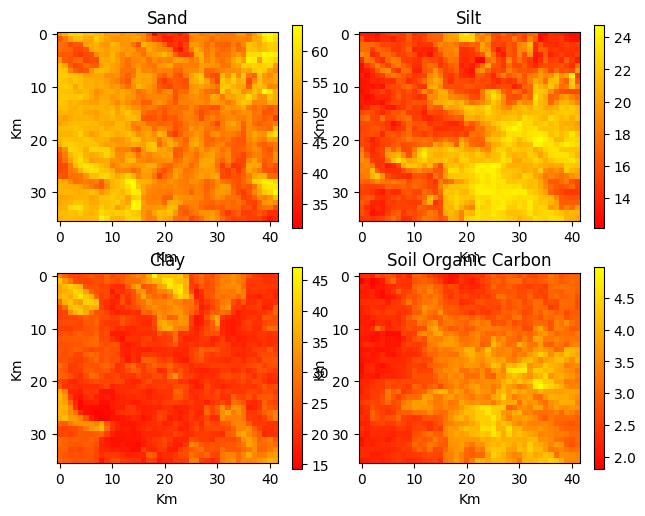

In [24]:
# Components
sand = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'SND')).select("SND_000_005_EV").mean()
silt = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'SLT')).select("SLT_000_005_EV").mean()
clay = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'CLY')).select("CLY_000_005_EV").mean()
soil_organic_carbon = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'SOC')).select("SOC_000_005_EV").mean()

sand_array = geemap.ee_to_numpy(sand, region=aoi, scale=1000)
silt_array = geemap.ee_to_numpy(silt, region=aoi, scale=1000)
clay_array = geemap.ee_to_numpy(clay, region=aoi, scale=1000)
soil_organic_carbon_array = geemap.ee_to_numpy(soil_organic_carbon, region=aoi, scale=1000)

plt.subplot(2, 2, 1)
plt.tight_layout()
plt.title("Sand")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(sand_array, cmap='autumn')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("Silt")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(silt_array, cmap='autumn')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title("Clay")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(clay_array, cmap='autumn')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title("Soil Organic Carbon")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(soil_organic_carbon_array, cmap='autumn')
plt.colorbar()

plt.savefig('images/soil_components.png')



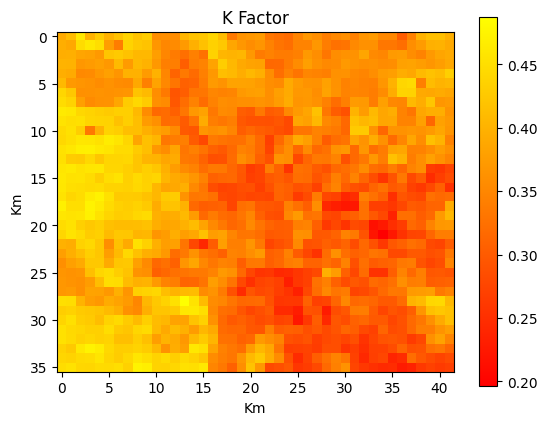

In [25]:
# Get the layers for sand, silt, clay, and organic carbon
sand =ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'SND')).select("SND_000_005_EV").mean()
silt = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'SLT')).select("SLT_000_005_EV").mean()
clay = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'CLY')).select("CLY_000_005_EV").mean()
soil_organic_carbon = ee.ImageCollection("CSIRO/SLGA").filter(ee.Filter.eq('attribute_code', 'SOC')).select("SOC_000_005_EV").mean()

# Convert organic carbon to organic matter
organic_matter = soil_organic_carbon.multiply(1.724)

# Calculate the M factor
M = silt.add(sand).multiply(100).subtract(clay)

structure = ee.Number(3)
permeability = ee.Number(3)

K_factor = (ee.Image(2.1).multiply(10**(-4))
            .multiply((ee.Image(12).subtract(organic_matter))
                      .multiply(M.pow(1.14)))
            .add(ee.Image(3.25).multiply(structure.subtract(2)))
            .add(ee.Image(2.5).multiply(permeability.subtract(3)))
           ).divide(100)

K_factor_array = geemap.ee_to_numpy(K_factor, region=aoi, scale=1000)
# Visualization parameters
vis_params = {
    'min': 0,
    'max': 0.05,  # Adjust based on expected K factor range
    'palette': ['blue', 'green', 'yellow', 'orange', 'red']
}

# Set up the map
Map = geemap.Map()
Map.centerObject(ee.Geometry.BBox(112.0, -44.0, 154.0, -9.0), 4)  # Center on Australia
Map.addLayer(K_factor, vis_params, 'Soil Erodibility (K factor)')
Map.to_html('maps/k_factor.html')

plt.title("K Factor")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(K_factor_array, cmap='autumn')
plt.colorbar()
plt.savefig('images/k_factor.png')
plt.show()


# LS Factor

In [10]:
# Get the DEM
dem = ee.ImageCollection("JAXA/ALOS/AW3D30/V3_2").select('DSM')
proj = dem.first().select(0).projection()
slope = ee.Terrain.slope(dem.mosaic().setDefaultProjection(proj)).clip(aoi)
dem = dem.mosaic().clip(aoi)

dem_array = geemap.ee_to_numpy(dem, region=aoi, scale=30)
slope_array = geemap.ee_to_numpy(slope, region=aoi, scale=30)

elevationVis = {
  'min': 0,
  'max': 5000,
  'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']
}

# LS Factor


Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(dem, elevationVis, 'DEM')
Map.addLayer(slope, {'min': 0, 'max': 60}, 'Slope')
Map.to_html('maps/dem.html')

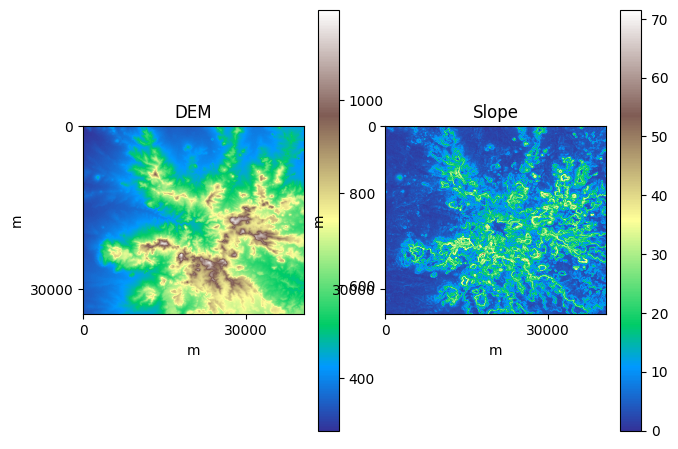

In [11]:
# Plot DEM and Slope
plt.subplot(1, 2, 1)
plt.tight_layout()
plt.title("DEM")
plt.xlabel("m")
plt.ylabel("m")
plt.imshow(dem_array, cmap='terrain')
plt.xticks(np.arange(0, dem_array.shape[1], 1000), np.arange(0, dem_array.shape[1] * 30, 30000))
plt.yticks(np.arange(0, dem_array.shape[0], 1000), np.arange(0, dem_array.shape[0] * 30, 30000))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Slope")
plt.xlabel("m")
plt.ylabel("m")
plt.imshow(slope_array, cmap='terrain')
plt.xticks(np.arange(0, dem_array.shape[1], 1000), np.arange(0, dem_array.shape[1] * 30, 30000))
plt.yticks(np.arange(0, dem_array.shape[0], 1000), np.arange(0, dem_array.shape[0] * 30, 30000))
plt.colorbar()
plt.savefig('images/dem_slope.png')

In [15]:
# Load the DEM ImageCollection and create a mosaic for the AOI
dem_collection = ee.ImageCollection("JAXA/ALOS/AW3D30/V3_2").filterBounds(aoi)
dem_mosaic = dem_collection.select("DSM").mosaic().clip(aoi)  # Select DSM band

# Calculate terrain products to get the slope in degrees
terrain = ee.Terrain.products(dem_mosaic)
slope = terrain.select('slope')

# Reproject slope to match DEM's projection
dem_projection = dem_mosaic.projection()
slope_reprojected = slope.reproject(crs=dem_projection, scale=dem_projection.nominalScale())

# Constants for the LS factor calculation
m = 0.4
n = 1.3
cell_size = dem_projection.nominalScale()  # Get cell size in meters

# Calculate the slope length (L factor)
slope_length = cell_size  # Approximates slope length for a grid-based approach
l_factor = ee.Image(slope_length).divide(22.13).pow(m)

# Calculate the slope steepness (S factor) with reprojected slope
s_factor = slope_reprojected.divide(100).sin().pow(n)

# Combine L and S factors to calculate the LS factor
ls_factor = l_factor.multiply(s_factor)

In [30]:
# Calculate the LS factor
LS = (ee.Image(10).multiply(slope.divide(22.1).tan().multiply(0.089)).pow(1.4)
      .multiply(ee.Image(0.065).add(ee.Image(0.045).multiply(ee.Image(180).subtract(ee.Image(180).subtract(slope)).divide(180))))
     )

In [39]:
# Load DEM data (e.g., SRTM) and clip to the area of interest.
dem = ee.Image("USGS/SRTMGL1_003").clip(aoi)

# Calculate slope in degrees as an ee.Image.
slope = ee.Terrain.slope(dem)

# Define the function to calculate the slope length (L) factor.
def calculate_L(slope_image, slope_length_m):
    # Convert slope length to an ee.Image for consistency.
    slope_length = ee.Image.constant(slope_length_m)
    
    # Convert slope in degrees to radians.
    slope_radians = slope_image.multiply(math.pi / 180)
    
    # Calculate m based on the slope steepness thresholds.
    m = slope_radians.expression(
        'b(0) < 1 ? 0.2 : b(0) < 3 ? 0.3 : b(0) < 4.5 ? 0.4 : 0.5'
    )

    # Calculate the L factor using Earth Engine methods.
    L = slope_length.divide(22.13).pow(m)
    return L

# Define the function to calculate the slope steepness (S) factor.
def calculate_S(slope_image):
    # Convert slope in degrees to radians.
    slope_radians = slope_image.multiply(math.pi / 180)
    
    # Calculate S factor based on slope angle thresholds.
    S = slope_radians.expression(
        'b(0) < 9 ? (10.8 * sin(b(0)) + 0.03) : (16.8 * sin(b(0)) - 0.50)',
        {'b': slope_radians}
    )
    return S

# Calculate L and S factors as ee.Images.
L_factor = calculate_L(slope, slope_length_m=22.13)
S_factor = calculate_S(slope)

# Calculate the LS factor by multiplying L and S.
LS_factor = L_factor.multiply(S_factor)

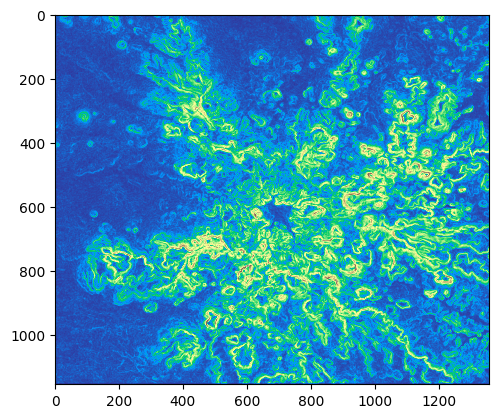

In [40]:
LS_array = geemap.ee_to_numpy(LS_factor, region=aoi, scale=30)
plt.imshow(LS_array, cmap='terrain')

# C Factor
PV fraction (**f**PV) was estimated based on the Modified Transformed Vegetation Index (MTVI)

$$
PV = 1.7208 \left( 1.2 (R_{NIR} - R_{green}) - 2.5 (R_{red} - R_{green}) \right) + 0.1004
$$



In [84]:
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(
    '2021-05-01', '2021-06-01'
)


# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )


dataset = dataset.map(apply_scale_factors)

# Get the bands
nir = dataset.select('SR_B5').mean().clip(aoi)
red = dataset.select('SR_B4').mean().clip(aoi)
green = dataset.select('SR_B3').mean().clip(aoi)


# PV 
A = nir.subtract(green).multiply(ee.Image(1.2))
B = red.subtract(green).multiply(ee.Image(2.5))
C = A.subtract(B)
D = C.multiply(ee.Image(1.7208))
PV = D.add(ee.Image(0.1004))
PV_limited = ee.Image(PV).min(1)  # Limit PV to a maximum of 1 (100%)

# PV = ee.Image(1.7208).multiply(
#     ee.Image(1.2).multiply(nir.subtract(green))
#     .subtract(ee.Image(2.5).multiply(red.subtract(green)))
# ).add(ee.Image(0.1004))


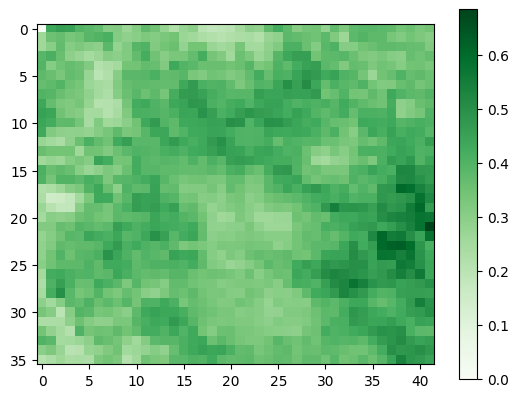

In [85]:
PV_array = geemap.ee_to_numpy(PV, region=aoi, scale=1000)
plt.imshow(PV_array, cmap='Greens')
plt.colorbar()

$$
NPV = 0.82\frac{(R_{SWIR} - R_{red})}{(R_{SWIR} + R_{red})} + 0.0753
$$

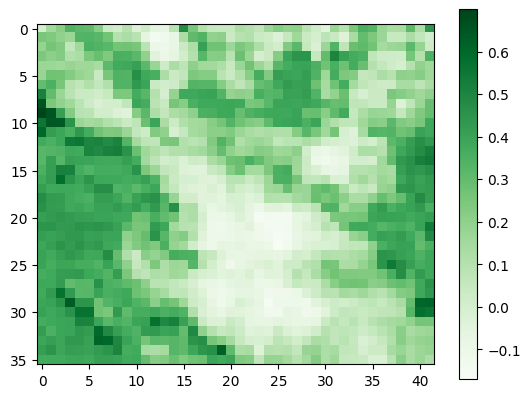

In [86]:
# Get the bands
swir = dataset.select('SR_B6').mean().clip(aoi)
# NPV
A = swir.subtract(red).divide(swir.add(red))
NPV = ee.Image(0.82).multiply(A).add(ee.Image(0.0753))

NPV_array = geemap.ee_to_numpy(NPV, region=aoi, scale=1000)
plt.imshow(NPV_array, cmap='Greens')
plt.colorbar()

$$
GC = PV + NPV
$$

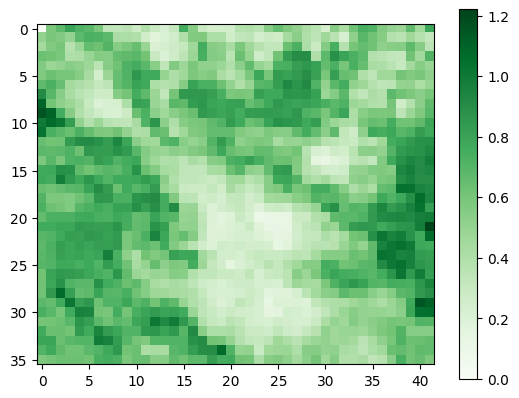

In [87]:
# GC
GC = PV.add(NPV)
GC_array = geemap.ee_to_numpy(GC, region=aoi, scale=1000)
plt.imshow(GC_array, cmap='Greens')
plt.colorbar()

$$
C_i = e^{-0.799-7.74GC_i+0.0449GC_i^2}(EI_{30})_i
$$


0.2027220974864583 0.0


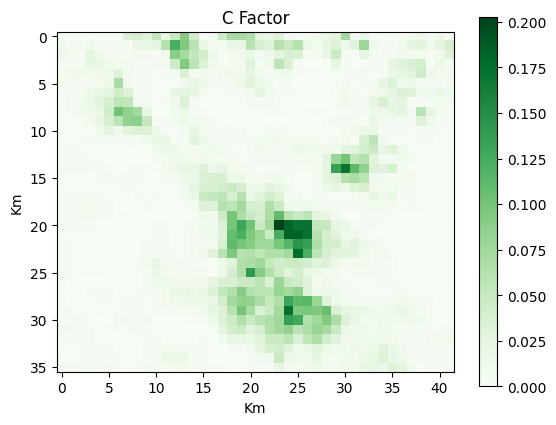

In [88]:
# C Factor
A = ee.Image(-0.799).subtract(ee.Image(7.74).multiply(GC)).add(ee.Image(0.0449).multiply(GC.pow(2)))
B = A.exp()
C = B.multiply(EI30)


C_array = geemap.ee_to_numpy(B, region=aoi, scale=1000)

Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(C, {'min': 0, 'max': 1}, 'C Factor')
Map.to_html('maps/c_factor.html')

plt.title("C Factor")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(C_array, cmap='Greens')
plt.colorbar()
plt.savefig('images/c_factor.png')
plt.show()


# Calculating RUSLE
$$
A = EI30 \times K \times LS \times C
$$

In [89]:
# RUSLE
soil_loss = EI30.multiply(K_factor).multiply(LS_factor).multiply(C)

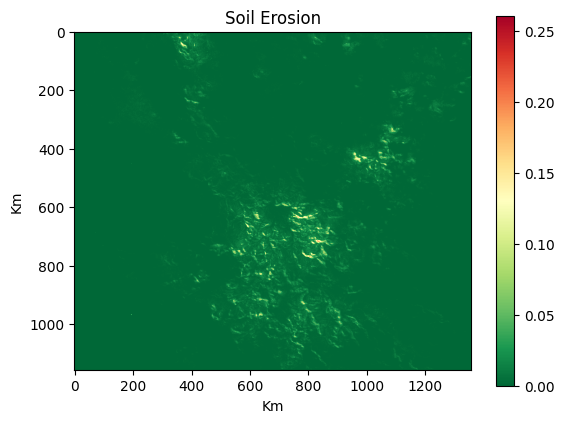

In [90]:
soil_loss_array = geemap.ee_to_numpy(soil_loss, region=aoi, scale=30)
plt.title("Soil Erosion")
plt.xlabel("Km")
plt.ylabel("Km")
plt.imshow(soil_loss_array, cmap='RdYlGn_r')
plt.colorbar()
plt.savefig('images/soil_erosion.png')
plt.show()

In [111]:
# Display the map

soil_loss_masked = soil_loss.updateMask(soil_loss.gt(0.01))

soil_loss_vis_minimal = {
  'min': 0,
  'max': 0.1,
  'palette': ['black', 'green', 'yellow', 'orange', 'red']
}

soil_loss_vis_normal = {
  'min': 0,
  'max': 1,
  'palette': ['black', 'green', 'yellow', 'orange', 'red']
}

Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(soil_loss_masked, soil_loss_vis_minimal, 'Soil Loss')
Map.to_html('maps/soil_loss_minimal.html')

Map2 = geemap.Map()
Map2.centerObject(aoi, 10)
Map2.addLayer(soil_loss_masked, soil_loss_vis_normal, 'Soil Loss')
Map2.to_html('maps/soil_loss_normal.html')